In [1]:
import sys,os,os.path
sys.path.append("/Users/user/Desktop/PhD/Repositories/IC/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
if not os.environ.get("ICTDIR"):
    os.environ["ICTDIR"] = "/Users/user/Desktop/PhD/Repositories/IC"

import invisible_cities.core.core_functions as     coref
import invisible_cities.io  .dst_io         as     dstio
from invisible_cities.io.pmaps_io import load_pmaps
from invisible_cities.io.pmaps_io import load_pmaps_as_df
from invisible_cities.database.load_db  import DataPMT, DataSiPM


from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [8, 6]
rcParams['font.size'] = 15


import re
import glob
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
import tables

from scipy.spatial import cKDTree
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from   invisible_cities.database               import load_db

from invisible_cities.io.pmaps_io import load_pmaps
from invisible_cities.io.pmaps_io import load_pmaps_as_df

In [ ]:
import tables as tb

In [3]:
detector_info = load_db.DataSiPM('next100', 0)

In [558]:
filename = '/Users/user/Desktop/PhD/NEXT/NEXT_testing/irene_files/15539/zero_cuts/run_15539_0001_ldc1.pmaps'

with tb.open_file(filename) as file:

    pmaps    = load_pmaps      (filename)
    pmt_info = file.root.PMAPS.S2Pmt
    sipm_info = file.root.PMAPS.S2Si

all_events = list(pmaps.keys())
s2 = pmaps[all_events[5]].s2s[0]
sipm = s2.sipms
pmt = s2.pmts

Mean (mu)     = 14.02
Sigma         = 6.78
Variance      = 45.98


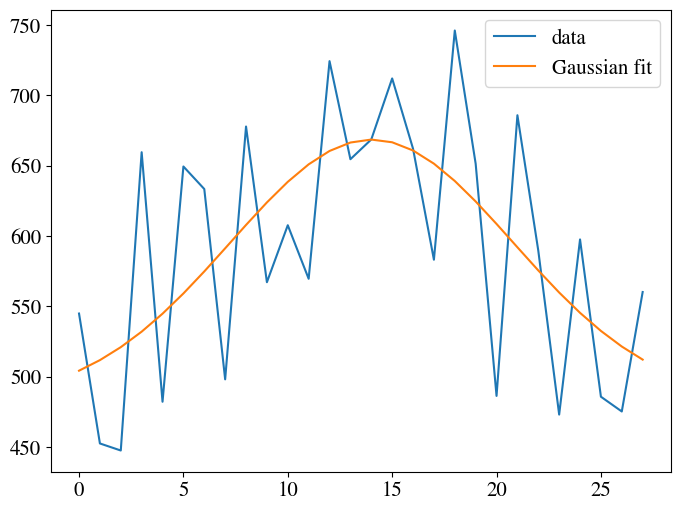

In [496]:
# your data
y = sipm.sum_over_sensors        # 1D array
x = np.arange(len(y))            # sample index

# Gaussian model
def gauss(x, A, mu, sigma, c):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + c

# initial guesses (robust enough for most S2 bumps)
A0 = np.max(y) - np.min(y)
mu0 = np.argmax(y)
sigma0 = len(y) / 10
c0 = np.min(y)

p0 = [A0, mu0, sigma0, c0]

# fit
popt, pcov = curve_fit(gauss, x, y, p0=p0)
A, mu, sigma, c = popt
variance = sigma**2

print(f"Mean (mu)     = {mu:.2f}")
print(f"Sigma         = {sigma:.2f}")
print(f"Variance      = {variance:.2f}")

# plot result fast
plt.plot(x, y, label="data")
plt.plot(x, gauss(x, *popt), label="Gaussian fit")
plt.legend()
plt.show()


Mean (mu)     = 12.59
Sigma         = 4.66
Variance      = 21.69


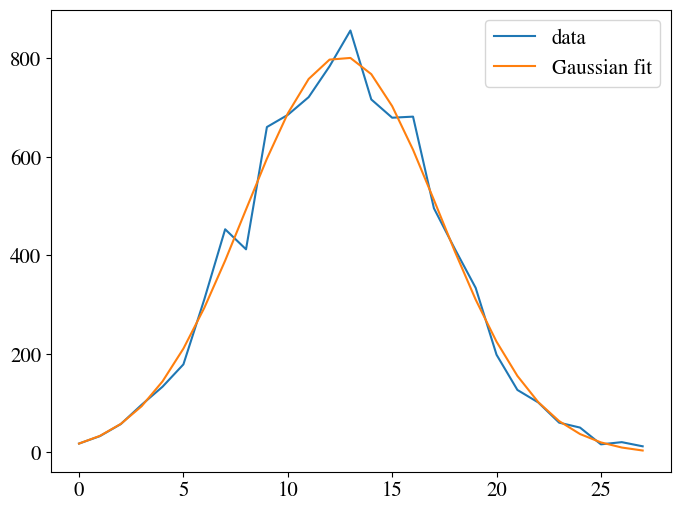

In [8]:


# your data
y = pmt.sum_over_sensors        # 1D array
x = np.arange(len(y))            # sample index

# Gaussian model
def gauss(x, A, mu, sigma, c):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + c

# initial guesses (robust enough for most S2 bumps)
A0 = np.max(y) - np.min(y)
mu0 = np.argmax(y)
sigma0 = len(y) / 10
c0 = np.min(y)

p0 = [A0, mu0, sigma0, c0]

# fit
popt, pcov = curve_fit(gauss, x, y, p0=p0)
A, mu, sigma, c = popt
variance = sigma**2

print(f"Mean (mu)     = {mu:.2f}")
print(f"Sigma         = {sigma:.2f}")
print(f"Variance      = {variance:.2f}")

# plot result fast
plt.plot(x, y, label="data")
plt.plot(x, gauss(x, *popt), label="Gaussian fit")
plt.legend()
plt.show()

# Starting work on constructing PSFs

In [24]:
def plot_sipms(sipm, circle_mask, radius_cut=75):

    max_sipm_id = np.where(sipm.sum_over_times == sipm.sum_over_times.max())[0][0]

    sipm_x_all = detector_info.X
    sipm_y_all = detector_info.Y

    sipm_charge_time_summed = sipm.sum_over_times
    sipm_ids = sipm.ids

    sipm_x_max = detector_info.X[max_sipm_id]
    sipm_y_max = detector_info.Y[max_sipm_id]

    min_amplitude = 0.0
    mask = sipm_charge_time_summed > min_amplitude

    sipm_x_active = detector_info.X[mask]
    sipm_y_active = detector_info.Y[mask]

    def make_circle(x, y, radius):
        circle = patches.Circle((x, y), radius, edgecolor='r', facecolor='none', linestyle='--', linewidth=2
                                )
        return circle
    
    fig, ax = plt.subplots(figsize=(9.7, 8))

    #ax.add_patch(make_circle(sipm_x_max, sipm_y_max, 75))

    ax.scatter(
        sipm_x_max,
        sipm_y_max,
        color="r",
        s=50,
        label="Max SiPM"
    )
    sipm_amplitude = sipm_charge_time_summed

    ax.scatter(
        sipm_x_all,
        sipm_y_all,
        color="k",
        s=0.5
    )
    sc = ax.scatter(
        sipm_x_active,
        sipm_y_active,
        c=sipm_amplitude[mask],
        cmap="viridis",
        s=10,
        label="Active SiPMs"
    )

    ax.scatter(
        sipm_x_all[circle_mask],
        sipm_y_all[circle_mask],
        edgecolor='r',
        facecolor='none',
        s=50,
        label=f"SiPMs within {radius_cut} mm"
    )

    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")

    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label("SiPM amplitude (PEs)")

    plt.show()


def make_mask(sipm, radius_cut=75):

    max_sipm_id = np.where(sipm.sum_over_times == sipm.sum_over_times.max())[0][0]

    sipm_x_all = detector_info.X
    sipm_y_all = detector_info.Y

    sipm_charge_time_summed = sipm.sum_over_times
    sipm_ids = sipm.ids

    sipm_x_max = detector_info.X[max_sipm_id]
    sipm_y_max = detector_info.Y[max_sipm_id]
    circle_mask = np.sqrt((sipm_x_all - sipm_x_max)**2 + (sipm_y_all - sipm_y_max)**2) < radius_cut
    
    return circle_mask


In [27]:
filename = '/Users/user/Desktop/PhD/NEXT/NEXT_testing/irene_files/15539/zero_cuts/run_15539_0001_ldc1.pmaps'

with tb.open_file(filename) as file:

    pmaps    = load_pmaps      (filename)
    pmt_info = file.root.PMAPS.S2Pmt
    sipm_info = file.root.PMAPS.S2Si

all_events = list(pmaps.keys())
s2 = pmaps[all_events[4]].s2s[0]
sipm = s2.sipms
pmt = s2.pmts

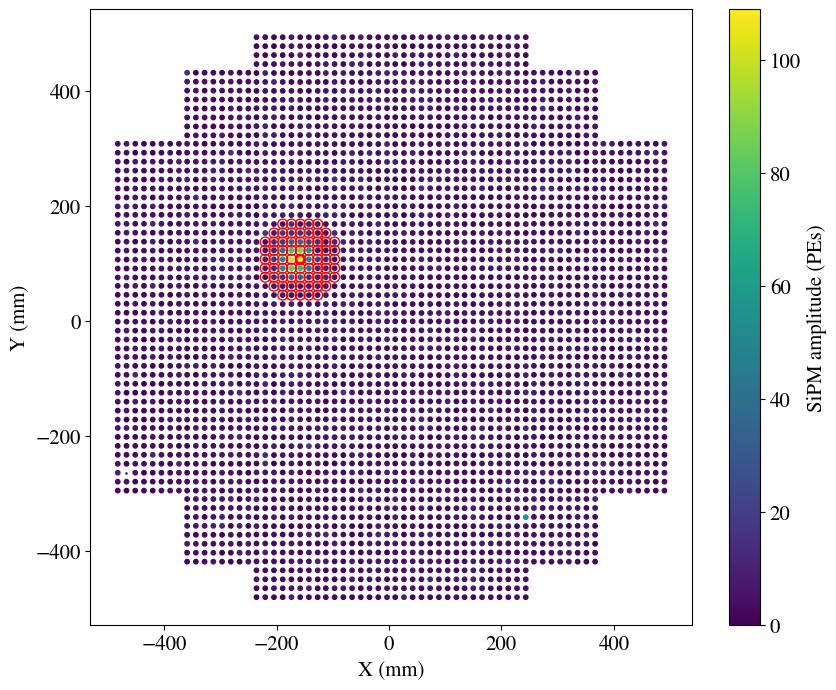

In [28]:
circle_mask = make_mask(sipm, radius_cut=75)

plot_sipms(sipm, circle_mask)

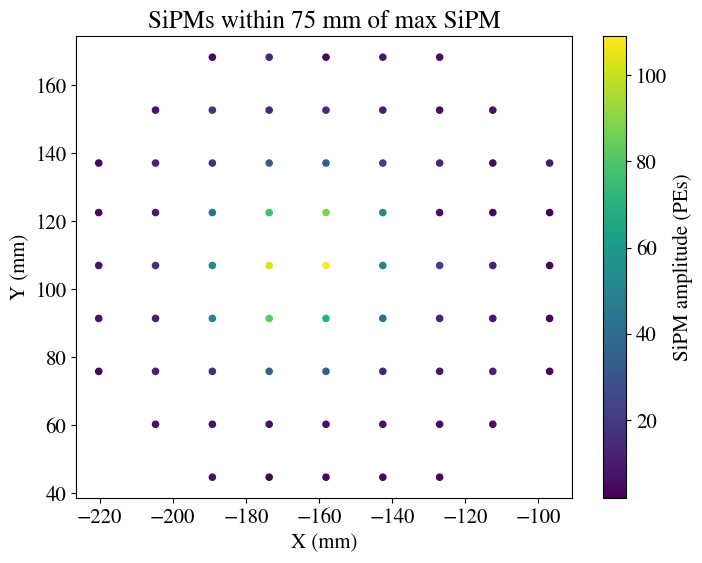

In [29]:
good_sipm_amplitudes = sipm.sum_over_times[circle_mask]
good_sipm_ids = sipm.ids[circle_mask]
good_sipm_x = detector_info.X[good_sipm_ids]
good_sipm_y = detector_info.Y[good_sipm_ids]
plt.scatter(good_sipm_x, good_sipm_y, c=good_sipm_amplitudes, cmap='viridis', s=20)
cbar = plt.colorbar()
cbar.set_label("SiPM amplitude (PEs)")
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.title("SiPMs within 75 mm of max SiPM")
plt.show()

In [586]:
sipm_df = pd.DataFrame(columns=['event', 'ids', 'time_summed', 'sensor_summed', 'max_sipm_id'])
pmt_df = pd.DataFrame(columns=['event', 'time_summed', 'sensor_summed'])

for pmaps in pmap_array:
    all_events = list(pmaps.keys())
    
    for evt in all_events:
        s2s = pmaps[evt].s2s
        
        if len(s2s) != 1:
            continue  # Skip events with no S2s
        s2 = s2s[0]
        sipm = s2.sipms
        pmt  = s2.pmts

        sipm_sum_over_times = sipm.sum_over_times
        pmt_sum_over_times = pmt.sum_over_times

        sipm_sum_over_sensors = sipm.sum_over_sensors
        pmt_sum_over_sensors = pmt.sum_over_sensors

        sipm_ids = sipm.ids

        max_sipm_id = np.where(sipm_sum_over_times == sipm_sum_over_times.max())[0][0]
        
        sipm_df = sipm_df.append({'event' : evt, 'ids' : sipm_ids, 'time_summed' : sipm_sum_over_times, 'sensor_summed' : sipm_sum_over_sensors, 'max_sipm_id' : max_sipm_id}, ignore_index=True)
        pmt_df = pmt_df.append({'event' : evt, 'time_summed' : pmt_sum_over_times, 'sensor_summed' : pmt_sum_over_sensors}, ignore_index=True)  

In [44]:
from invisible_cities.reco.xy_algorithms import barycenter

In [589]:
def get_barycenter_pos(sipm_coords, sipm_amplitudes, threshold=5):

    barycentre_info = barycenter(sipm_coords, sipm_amplitudes, threshold)[0]
    barycentre_x = barycentre_info._xy.x
    barycentre_y = barycentre_info._xy.y  

    return barycentre_x, barycentre_y

In [590]:
sipm = sipm_list[0]

In [591]:
def plot_bary(sipm, radius_cut=75):
    
    sipm_x_all = detector_info.X
    sipm_y_all = detector_info.Y

    sipm_x_max = detector_info.X[sipm.max_sipm_id]
    sipm_y_max = detector_info.Y[sipm.max_sipm_id]

    circle_mask = make_mask(sipm)
    good_sipm_amplitudes = sipm.time_summed[circle_mask]
    good_sipm_x = sipm_x_all[circle_mask]
    good_sipm_y = sipm_y_all[circle_mask]

    # finding barycentre
    good_sipm_coords = np.column_stack((good_sipm_x.values, good_sipm_y.values))
    barycentre_x, barycentre_y = get_barycenter_pos(good_sipm_coords, good_sipm_amplitudes, 5)
    
    fig, ax = plt.subplots(figsize=(9.7, 8))

    ax.scatter(
        sipm_x_max,
        sipm_y_max,
        color="r",
        s=50,
        label="Max SiPM"
    )

    ax.scatter(
        sipm_x_all,
        sipm_y_all,
        color="k",
        s=0.5
    )
    sc = ax.scatter(
        sipm_x_all,
        sipm_y_all,
        c=sipm.time_summed,
        cmap="viridis",
        s=10,
        label="Active SiPMs"
    )

    ax.scatter(barycentre_x, barycentre_y, color='red', s=100, marker='X', label='Barycentre')


    ax.set_xlabel("X (mm)")
    ax.set_ylabel("Y (mm)")

    cbar = fig.colorbar(sc, ax=ax)
    cbar.set_label("SiPM amplitude (PEs)")

    plt.show()


def make_mask(sipm, radius_cut=75):

    max_sipm_id = sipm.max_sipm_id

    sipm_x_all = detector_info.X
    sipm_y_all = detector_info.Y

    sipm_x_max = detector_info.X[max_sipm_id]
    sipm_y_max = detector_info.Y[max_sipm_id]
    circle_mask = np.sqrt((sipm_x_all - sipm_x_max)**2 + (sipm_y_all - sipm_y_max)**2) < radius_cut
    
    return circle_mask


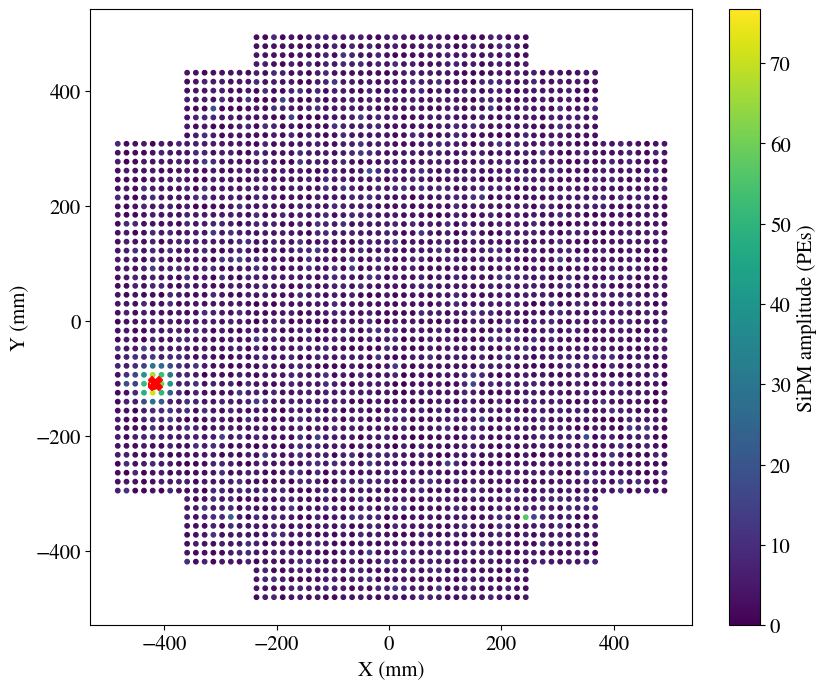

In [610]:
sipm_test = sipm_df[sipm_df.event == 512].iloc[0]
plot_bary(sipm_test)

In [593]:
def plot_bary_zoomed(sipm):

    circle_mask = make_mask(sipm, 75)

    good_sipm_amplitudes = sipm.time_summed[circle_mask]
    good_sipm_ids = sipm.ids[circle_mask]
    good_sipm_x = detector_info.X[good_sipm_ids]
    good_sipm_y = detector_info.Y[good_sipm_ids]

    good_sipm_coords = np.column_stack((good_sipm_x.values, good_sipm_y.values))
    barycentre_x, barycentre_y = get_barycenter_pos(good_sipm_coords, good_sipm_amplitudes, threshold=5)


    sc = plt.scatter(
        good_sipm_x, good_sipm_y,
        c=good_sipm_amplitudes,
        cmap='viridis',
        s=20,
        vmin=good_sipm_amplitudes.min(),
        vmax=good_sipm_amplitudes.max())  # ensures colorbar scales correctly)   
    plt.scatter(barycentre_x, barycentre_y, color='red', s=100, marker='X', label='Barycentre')

    cbar = plt.colorbar(sc)
    cbar.set_label("SiPM amplitude (PEs)")
    plt.xlabel("X (mm)")
    plt.ylabel("Y (mm)")
    plt.title("SiPMs within 75 mm of max SiPM")
    plt.show()

    print(f"The distance between the most energetic SiPM and the barycentre is {np.sqrt((barycentre_x - detector_info.X[np.where(sipm.time_summed == sipm.time_summed.max())[0][0]])**2 + (barycentre_y - detector_info.Y[np.where(sipm.time_summed == sipm.time_summed.max())[0][0]])**2):.2f} mm")

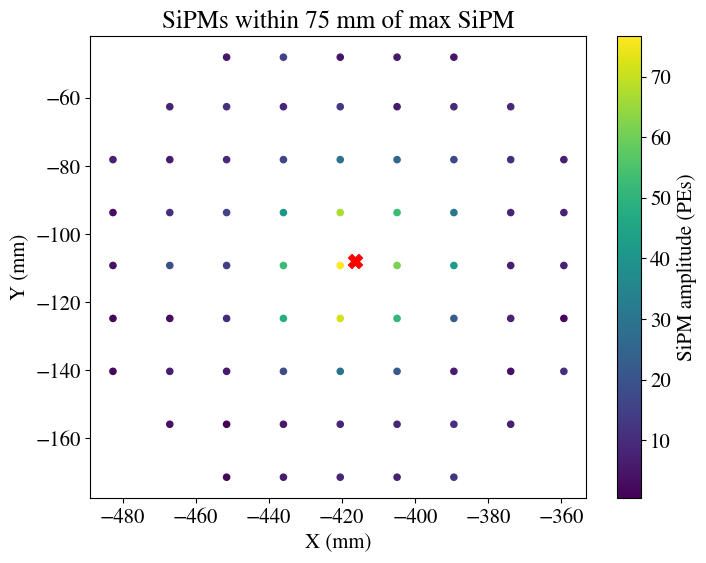

The distance between the most energetic SiPM and the barycentre is 4.35 mm


In [594]:
plot_bary_zoomed(sipm_test)